<a href="https://colab.research.google.com/github/sridharsakkari/SOC_work/blob/main/State%20Estimation%20LSTM%2018650_UDDS_US06%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/sridharsakkari/SOC_work.git

fatal: destination path 'SOC_work' already exists and is not an empty directory.


In [4]:
import numpy as np
from numpy import mean,std
from random import randint
import pandas as pd

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from keras.models import Sequential
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D,add,BatchNormalization,Activation,AveragePooling2D,Dropout
from keras.layers import LSTM,Bidirectional
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
from keras.optimizers import SGD,Adam

from keras.models import load_model,Model
from keras.backend import placeholder
from keras.initializers import glorot_uniform
#from keras.utils import multi_gpu_model
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import os
plt.rcParams["figure.figsize"] = (16,8)
import plotly
from plotly.express import line,scatter
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import scipy.io as sio

data = sio.loadmat('/content/SOC_work/UDDS_0.mat')
I = data['meas']['Current'][0][0]
V= data['meas']['Voltage'][0][0]
T = data['meas']['Battery_Temp_degC'][0][0]
Ah = data['meas']['Ah'][0][0]

UDDS_data_0 = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
UDDS_data_0.columns = ['Strom','Spannung','Temperatur','Kapazitat']

SoC = [1]
for i in range(1,len(UDDS_data_0)):

    SoC.append(SoC[i-1]+0.1*UDDS_data_0['Strom'].iloc[i-1]/(2.9*3600))


UDDS_data_0['SoC'] = SoC


data = sio.loadmat('/content/SOC_work/UDDS_10.mat')
I = data['meas']['Current'][0][0]
V= data['meas']['Voltage'][0][0]
T = data['meas']['Battery_Temp_degC'][0][0]
Ah = data['meas']['Ah'][0][0]

UDDS_data_10 = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
UDDS_data_10.columns = ['Strom','Spannung','Temperatur','Kapazitat']

SoC = [1]
for i in range(1,len(UDDS_data_10)):

    SoC.append(SoC[i-1]+0.1*UDDS_data_10['Strom'].iloc[i-1]/(2.9*3600))


UDDS_data_10['SoC'] = SoC



data = sio.loadmat('/content/SOC_work/UDDS_25.mat')
I = data['meas']['Current'][0][0]
V= data['meas']['Voltage'][0][0]
T = data['meas']['Battery_Temp_degC'][0][0]
Ah = data['meas']['Ah'][0][0]

UDDS_data_25 = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
UDDS_data_25.columns = ['Strom','Spannung','Temperatur','Kapazitat']

SoC = [1]
for i in range(1,len(UDDS_data_25)):

    SoC.append(SoC[i-1]+0.1*UDDS_data_25['Strom'].iloc[i-1]/(2.9*3600))


UDDS_data_25['SoC'] = SoC



#data = sio.loadmat('US06.mat')  
#I = data['meas']['Current'][0][0]
#V= data['meas']['Voltage'][0][0]
#T = data['meas']['Battery_Temp_degC'][0][0]
#Ah = data['meas']['Ah'][0][0]

#US06_data = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
#US06_data.columns = ['Strom','Spannung','Temperatur','Kapazitat']

In [6]:
data = sio.loadmat('/content/SOC_work/US06_0.mat')
I = data['meas']['Current'][0][0]
V= data['meas']['Voltage'][0][0]
T = data['meas']['Battery_Temp_degC'][0][0]
Ah = data['meas']['Ah'][0][0]

US06_data_0 = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
US06_data_0.columns = ['Strom','Spannung','Temperatur','Kapazitat']

SoC = [1]
for i in range(1,len(US06_data_0)):

    SoC.append(SoC[i-1]+0.1*US06_data_0['Strom'].iloc[i-1]/(2.9*3600))


US06_data_0['SoC'] = SoC


data = sio.loadmat('/content/SOC_work/US06_10.mat')
I = data['meas']['Current'][0][0]
V= data['meas']['Voltage'][0][0]
T = data['meas']['Battery_Temp_degC'][0][0]
Ah = data['meas']['Ah'][0][0]

US06_data_10 = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
US06_data_10.columns = ['Strom','Spannung','Temperatur','Kapazitat']

SoC = [1]
for i in range(1,len(US06_data_10)):

    SoC.append(SoC[i-1]+0.1*US06_data_10['Strom'].iloc[i-1]/(2.9*3600))


US06_data_10['SoC'] = SoC



data = sio.loadmat('/content/SOC_work/US06_25.mat')
I = data['meas']['Current'][0][0]
V= data['meas']['Voltage'][0][0]
T = data['meas']['Battery_Temp_degC'][0][0]
Ah = data['meas']['Ah'][0][0]

US06_data_25 = pd.concat((pd.DataFrame(I),pd.DataFrame(V),pd.DataFrame(T),pd.DataFrame(Ah)),axis = 1)
US06_data_25.columns = ['Strom','Spannung','Temperatur','Kapazitat']

SoC = [1]
for i in range(1,len(US06_data_25)):

    SoC.append(SoC[i-1]+0.1*US06_data_25['Strom'].iloc[i-1]/(2.9*3600))


US06_data_25['SoC'] = SoC

In [7]:
UDDS_data = pd.concat((UDDS_data_0,UDDS_data_10,UDDS_data_25),axis = 0)
US06_data = pd.concat((US06_data_0,US06_data_10,US06_data_25),axis = 0)


In [8]:
UDDS_data.to_csv('/content/SOC_work/UDDS_data.csv')
US06_data.to_csv('/content/SOC_work/US06_data.csv')

In [9]:
UDDS_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563174 entries, 0 to 224186
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Strom       563174 non-null  float64
 1   Spannung    563174 non-null  float64
 2   Temperatur  563174 non-null  float64
 3   Kapazitat   563174 non-null  float64
 4   SoC         563174 non-null  float64
dtypes: float64(5)
memory usage: 25.8 MB


In [10]:
UDDS_data.pop('Kapazitat')

0        -0.00000
1        -0.00000
2        -0.00000
3        -0.00000
4        -0.00001
           ...   
224182   -2.70149
224183   -2.70149
224184   -2.70149
224185   -2.70149
224186   -2.70149
Name: Kapazitat, Length: 563174, dtype: float64

In [11]:
(UDDS_data.corr())

,Strom,Spannung,Temperatur,SoC
Strom,1.000000,0.244047,0.064130,0.000423
Spannung,0.244047,1.000000,0.052140,0.948257
Temperatur,0.064130,0.052140,1.000000,-0.101446
SoC,0.000423,0.948257,-0.101446,1.000000


In [31]:
n_i = 1 # timesteps
features = len(UDDS_data.columns)-1
n_o = 1 #prediction time step

In [32]:
#series to supervised series data

def series2supervised(df,n_i,n_o):

    n_vars = df.shape[1]

    cols, names = list(),list()

    for i in range(n_i,0,-1):

        cols.append(df.shift(i))

        names += [('var%d(t-%d)') %((j+1,i)) for j in range(n_vars)]

    
    for i in range(n_o):
        cols.append(df.shift(i))

    for j in range(n_vars):

        for i in range(0,n_o):

            if i== 0:
                names+=[('var%d(t)') %(j+1)]

            else:
                names +=[('var%d(t+%d)')%((j+1,i))]

    agg = pd.concat(cols,axis=1)
    agg.columns = names

    agg.dropna(inplace = True)


    return names,agg

    

In [33]:
names,data_LSTM = series2supervised(UDDS_data,n_i,n_o)

In [34]:
data_LSTM

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,-0.01143,4.17416,0.550856,1.000000,-0.05063,4.17158,0.550856,1.000000
2,-0.05063,4.17158,0.550856,1.000000,-0.06125,4.17030,0.550856,0.999999
3,-0.06125,4.17030,0.550856,0.999999,-0.06533,4.16901,0.550856,0.999999
4,-0.06533,4.16901,0.550856,0.999999,-0.06615,4.16772,0.550856,0.999998
5,-0.06615,4.16772,0.550856,0.999998,-0.06615,4.16708,0.550856,0.999998
...,...,...,...,...,...,...,...,...
224182,0.00000,3.31605,26.269570,0.069974,0.00000,3.31605,26.269570,0.069974
224183,0.00000,3.31605,26.269570,0.069974,0.00000,3.31605,26.269570,0.069974
224184,0.00000,3.31605,26.269570,0.069974,0.00000,3.31605,26.269570,0.069974
224185,0.00000,3.31605,26.269570,0.069974,0.00000,3.31605,26.258360,0.069974


In [35]:
data_x = data_LSTM[data_LSTM.columns[:n_i*features+n_o-1]]
data_y = data_LSTM[data_LSTM.columns[-n_o:]]

In [36]:
#split train and test data 

x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,shuffle= False,test_size=0.3)

In [37]:
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,shuffle=False,test_size = 0.5)

In [19]:
x_val

,var1(t-1),var2(t-1),var3(t-1),var4(t-1)
55235,-0.47201,3.91617,25.84366,0.787191
55236,-0.55040,3.91359,25.84366,0.787186
55237,-0.58143,3.91231,25.84366,0.787181
55238,-0.58960,3.91166,25.84366,0.787175
55239,-0.59123,3.91166,25.84366,0.787170
...,...,...,...,...
139706,-1.00118,3.55717,26.05661,0.428015
139707,-1.00118,3.55717,26.05661,0.428006
139708,-1.00118,3.55717,26.05661,0.427996
139709,-1.00036,3.55717,26.05661,0.427987


In [38]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_val_scaled = scaler.fit_transform(x_val)

y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1,1))
y_val_scaled = scaler.fit_transform(np.array(y_val).reshape(-1,1))

In [39]:
x_train_LSTM = x_train_scaled.reshape(x_train.shape[0],n_i,features)
x_test_LSTM = x_test_scaled.reshape(x_test.shape[0],n_i,features)
x_val_LSTM = x_val_scaled.reshape(x_val.shape[0],n_i,features)

y_train_LSTM = y_train_scaled
y_test_LSTM = y_test_scaled
y_val_LSTM = y_val_scaled

In [40]:
x_train_LSTM.shape

(394221, 1, 3)

In [23]:
#convert data into LSTM data 
#def create_dataset(X, y, time_steps=1):#
    #Xs, ys = [], []
    #for i in range(len(X) - time_steps):
        #v = X.iloc[i:(i + time_steps)].values
        #Xs.append(v)        
        #ys.append(y.iloc[i + time_steps])
    #return np.array(Xs), np.array(ys)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 512)            534528    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 256)            656384    
_________________________________________________________________
dropout (Dropout)            (None, 1, 256)            0         
_________________________________________________________________
layer3 (Dense)               (None, 1, 50)             12850     
_________________________________________________________________
layer4 (Dense)               (None, 1, 10)             510       
_________________________________________________________________
layer5 (Dense)               (None, 1, 1)              11    

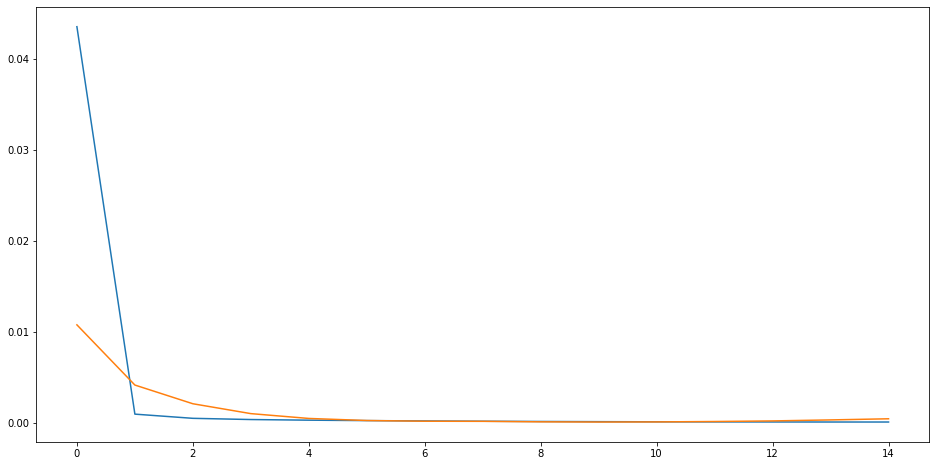

In [24]:
def LSTM_model(X):
    
    np.random.seed(1)

    X_i = Input(shape = (X.shape[1],X.shape[2]))
    
    X = Bidirectional(LSTM(256,activation = 'tanh',kernel_initializer = 'glorot_uniform',return_sequences=True,input_shape=(X.shape[1:])))(X_i)
    

    X = Bidirectional(LSTM(128,activation = 'tanh',kernel_initializer = 'glorot_uniform',return_sequences =True))(X)

    X = (LSTM(128,activation = 'tanh',kernel_initializer = 'glorot_uniform',return_sequences =True))(X)

    
    X = Dropout(0.2)(X)
    
    X = Dense(50,activation='tanh',name='layer3')(X)
    
    X = Dense(10,activation='tanh',name='layer4')(X)
    
    X = Dense(1,activation= 'relu',name='layer5')(X)

    model = Model(inputs = X_i,outputs = X)
    
    return model


model = LSTM_model(x_train_LSTM)
model.summary()
#plot_model(model, show_shapes=True, to_file='LSTM_SoC.png')
np.random.seed(1)
model.compile(optimizer = Adam(lr=0.00001),loss = 'mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
history = model.fit(x_train_LSTM,y_train_LSTM,batch_size = 64, epochs = 400,validation_data = (x_val_LSTM,y_val_LSTM),verbose = 1,shuffle = False,callbacks=[es])
plt.plot(history.history['loss'],label ='train')
plt.plot(history.history['val_loss'],label = 'val loss')

model.save_weights("/content/SOC_work/model_22.12.h5")

In [25]:
predictions_train = model.predict(x_train_LSTM)
R2 = r2_score(y_train_LSTM,predictions_train.reshape(-1,1))
print(R2)


predictions_val = model.predict(x_val_LSTM);
R2 = r2_score(y_val_LSTM,predictions_val.reshape(-1,1))
print(R2)

predictions_test = model.predict(x_test_LSTM);
R2 = r2_score(y_test_LSTM,predictions_test.reshape(-1,1))
print(R2)

0.9916963539659795
0.9940731507745567
0.9923224257333282


In [ ]:
test_sample= scaler.fit_transform(np.array([4.2,4.32,11]).reshape(1,-1)).reshape(1,1,3)
test_op= model.predict(test_sample)

In [26]:
pred_train = scaler.inverse_transform(predictions_train.reshape(-1,1))
y_act_train = scaler.inverse_transform(y_train_LSTM)

pred_val = scaler.inverse_transform(predictions_val.reshape(-1,1))
y_act_val = scaler.inverse_transform(y_val_LSTM)

pred_test = scaler.inverse_transform(predictions_test.reshape(-1,1))
y_act_test = scaler.inverse_transform(y_test_LSTM)

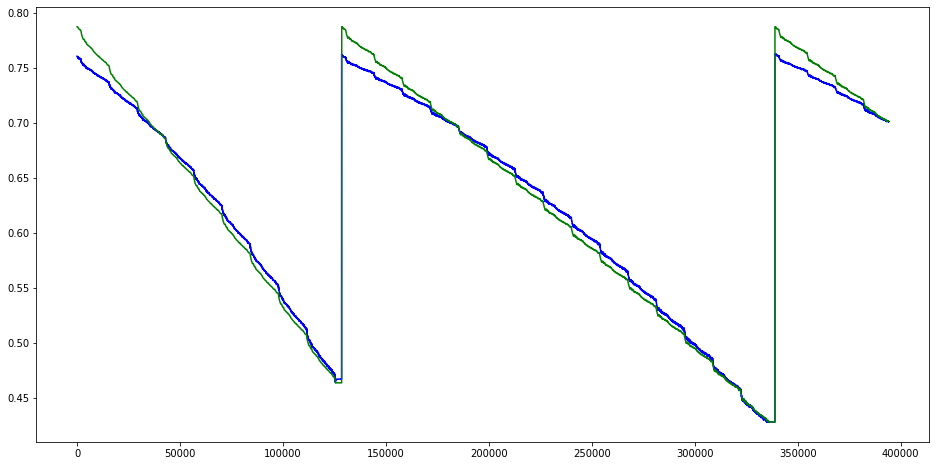

In [27]:
plt.plot(pred_train,'-b')
plt.plot(y_act_train,'-g')

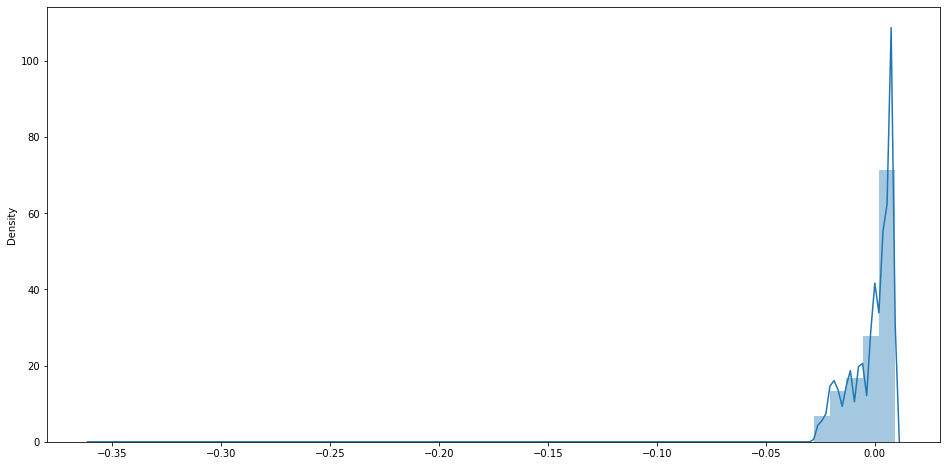

In [28]:
sns.distplot(pred_train-y_act_train)

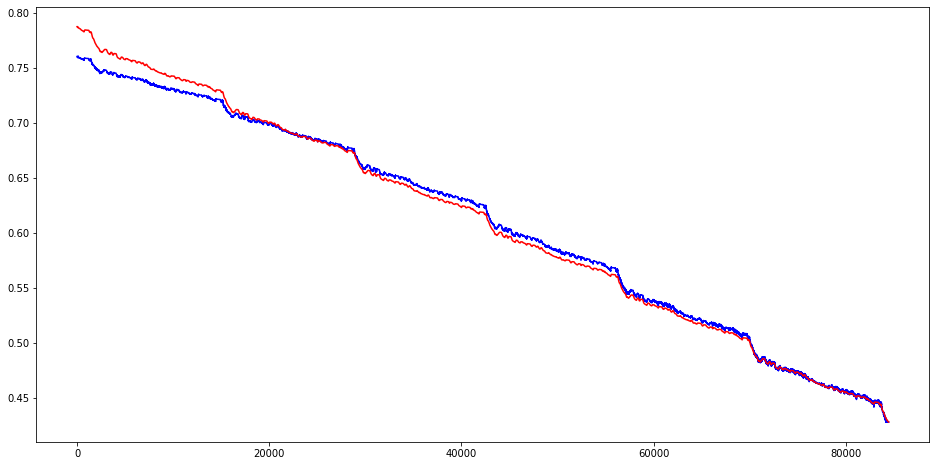

In [29]:
plt.plot(pred_val,'-b')
plt.plot(y_act_val,'-r')

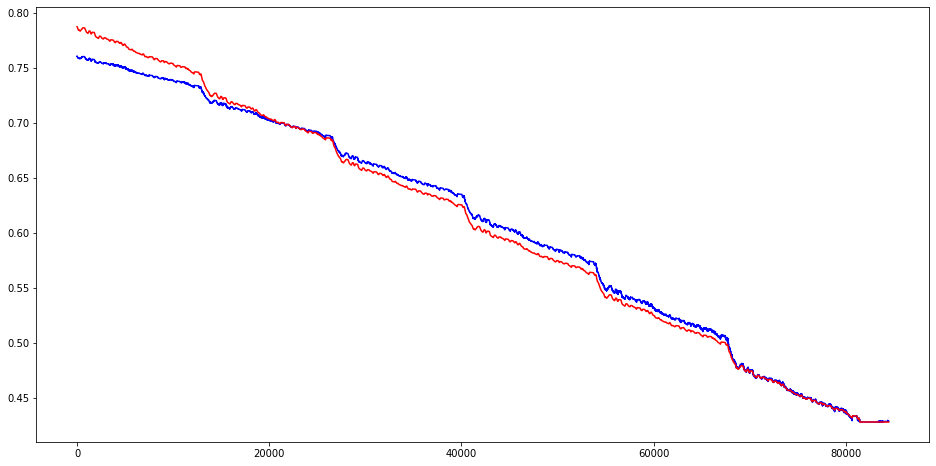

In [30]:
plt.plot(pred_test,'-b')
plt.plot(y_act_test,'-r')

In [ ]:
df2 = pd.concat((pd.DataFrame(y_act_train),pd.DataFrame(pred_train)),axis =1)
df2.columns = ['train_act','train_pred']

In [ ]:
df3 = pd.concat((pd.DataFrame(y_act_test),pd.DataFrame(pred_test)),axis =1)
df3.columns = ['test_act','test_pred']

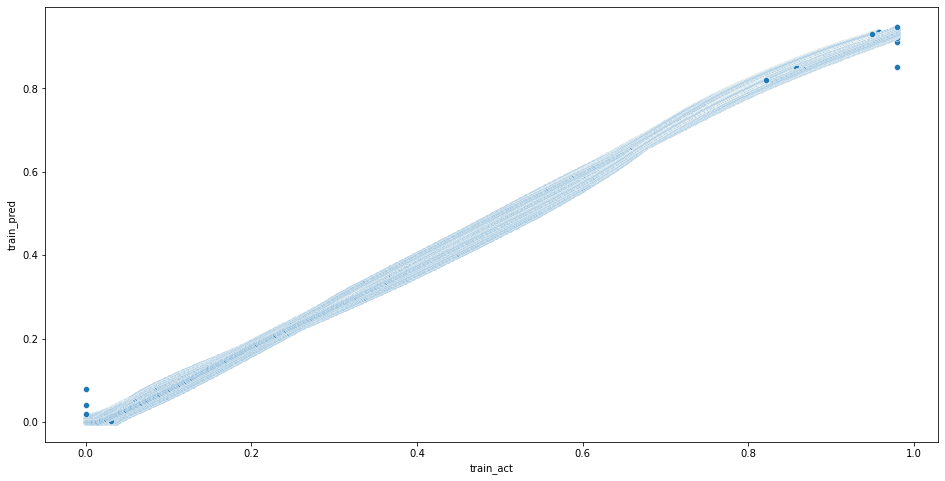

In [ ]:
sns.scatterplot(x='train_act',y='train_pred',data = df2)

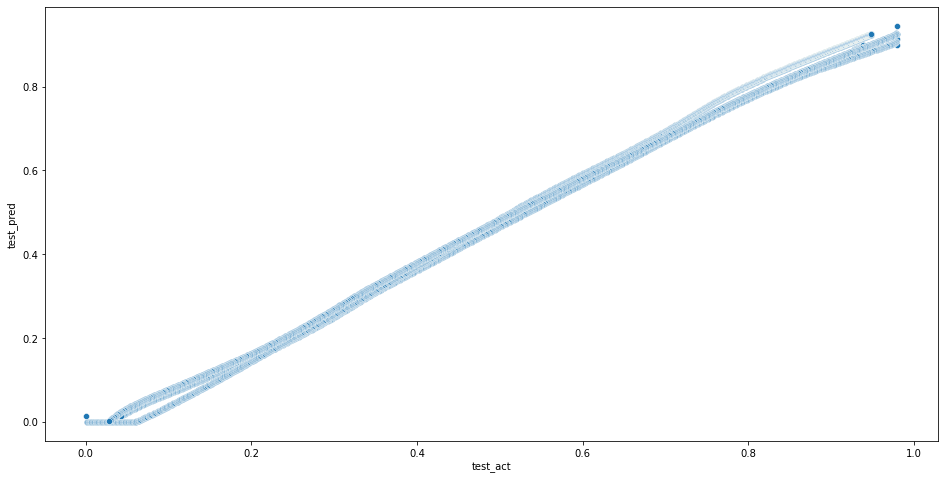

In [ ]:
sns.scatterplot(x='test_act',y='test_pred',data = df3,palette='bright',alpha=1)

In [ ]:
line(df3['test_act']-df3['test_pred'])

Unsupported

In [ ]:
# DNN feedforward network 
def DNN(X):
    np.random.seed(1)
    model1 = Sequential()

    model1.add(Dense(3,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros',input_dim=X.shape[1]))

    model1.add(Dense(512,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))

    model1.add(Dense(256,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))

    model1.add(Dense(100,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))

    model1.add(Dense(10,activation='tanh',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))
    
    model1.add(Dense(1,activation='linear',kernel_initializer = 'glorot_uniform',bias_initializer = 'zeros'))
    
    model1.compile(loss='mse', optimizer=Adam(lr=0.000001))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
    
    history = model1.fit(x_train_scaled,y_train_scaled,batch_size = 32, epochs = 100,validation_data = (x_test_scaled,y_test_scaled),verbose = 1,shuffle = False,callbacks=[es])
    
    plt.plot(history.history['loss'],label ='train')
    plt.plot(history.history['val_loss'],label = 'val loss')
    
    
    return model1


In [ ]:
model1 = DNN(x_train_scaled)
model1.save_weights("model.h5")

In [ ]:
predictions_train = model1.predict(x_train_scaled);
R2 = r2_score(y_train_scaled,predictions_train)
print(R2)

predictions_test = model1.predict(x_test_scaled);
R2 = r2_score(y_test_scaled,predictions_test)
print(R2)

pred_train = scaler.inverse_transform(predictions_train)
y_act_train = scaler.inverse_transform(y_train_scaled)

pred_test = scaler.inverse_transform(predictions_test)
y_act_test = scaler.inverse_transform(y_test_scaled)


                         
plt.plot(pred_train)
plt.plot(y_act_train)

In [ ]:
plt.plot(pred_test)
plt.plot(y_act_test)